<a href="https://colab.research.google.com/github/jayawale1211/Melanoma-detection-Assignment/blob/main/CNN_Assignment_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [86]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/Train/")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [78]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

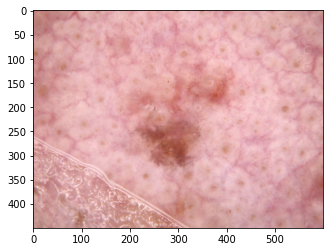

In [9]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

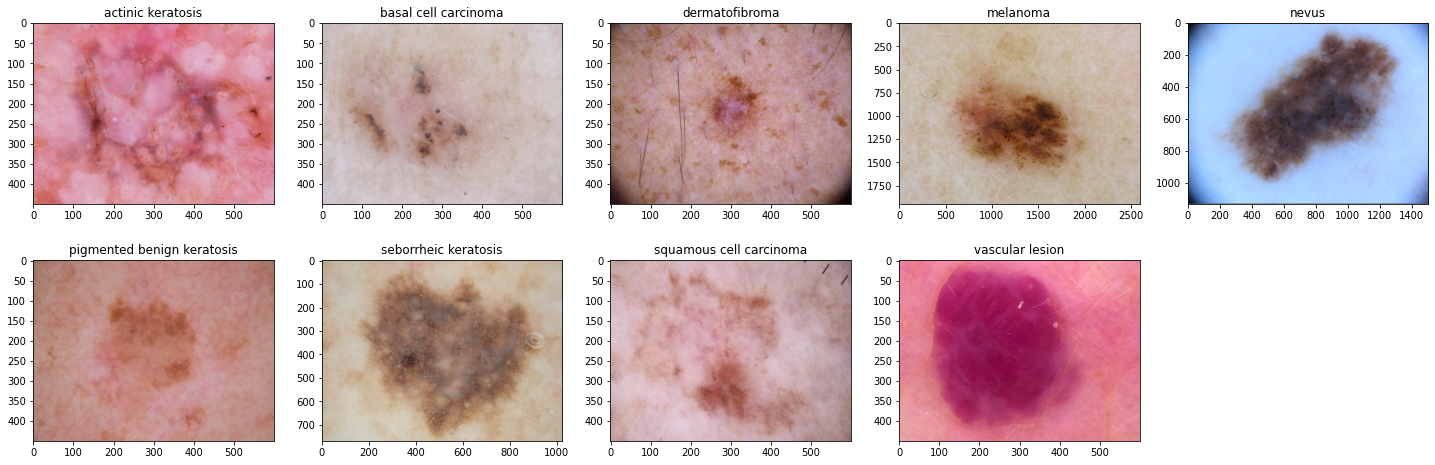

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [13]:
### Your code goes here
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 230s 847ms/step - loss: 3.2353 - accuracy: 0.1964 - val_loss: 1.9908 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 1.8381 - accuracy: 0.3454 - val_loss: 1.6066 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5327 - accuracy: 0.4676 - val_loss: 1.5713 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 4s 70ms/step - loss: 1.4030 - accuracy: 0.5067 - val_loss: 1.5049 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: 1.2304 - accuracy: 0.5614 - val_loss: 1.4965 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 4s 68ms/step - loss: 1.1277 - accuracy: 0.5893 - val_loss: 1.4990 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 4s 71ms/step - loss: 1.0025 - accuracy: 0.6406 - val_loss: 1.6465 - val_accuracy: 0.5302
Epoch 8/20

### Visualizing training results

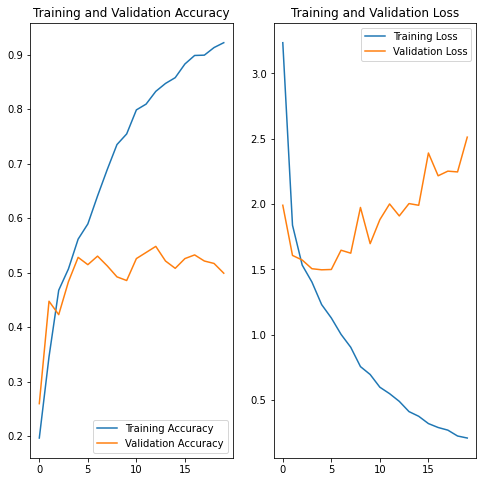

In [17]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

#### From the plot above it show that as training loss decreases with epochs the validation loss increases. It also evident that training accuracy and validation accuracy are showing large difference for accuracy thus it is confirmed that the model is overfitting.

### One of the cause of overffiting is not sufficient training data thus we can use a data augmentation approach to generate additional training data from existing dataset by augmenting them using random transformations.

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

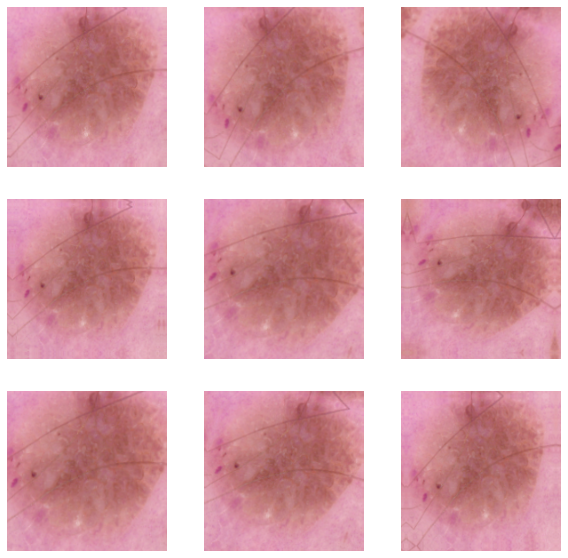

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [80]:
# CNN Model
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compiling the model

In [81]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 45, 45, 128)      0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 45, 45, 128)     

### Training the model

In [82]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
113/113 [==============================] - 21s 158ms/step - loss: 2.2871 - accuracy: 0.2706 - val_loss: 1.4886 - val_accuracy: 0.4322
Epoch 2/20
113/113 [==============================] - 19s 159ms/step - loss: 1.4722 - accuracy: 0.4439 - val_loss: 1.4496 - val_accuracy: 0.4300
Epoch 3/20
113/113 [==============================] - 19s 162ms/step - loss: 1.2926 - accuracy: 0.5264 - val_loss: 1.2902 - val_accuracy: 0.5144
Epoch 4/20
113/113 [==============================] - 19s 165ms/step - loss: 1.0636 - accuracy: 0.6219 - val_loss: 1.3298 - val_accuracy: 0.5111
Epoch 5/20
113/113 [==============================] - 19s 159ms/step - loss: 0.9018 - accuracy: 0.6817 - val_loss: 1.0784 - val_accuracy: 0.6211
Epoch 6/20
113/113 [==============================] - 19s 161ms/step - loss: 0.7028 - accuracy: 0.7592 - val_loss: 1.1169 - val_accuracy: 0.5989
Epoch 7/20
113/113 [==============================] - 19s 159ms/step - loss: 0.6236 - accuracy: 0.7875 - val_loss: 1.0404 - val_ac

### Visualizing the results

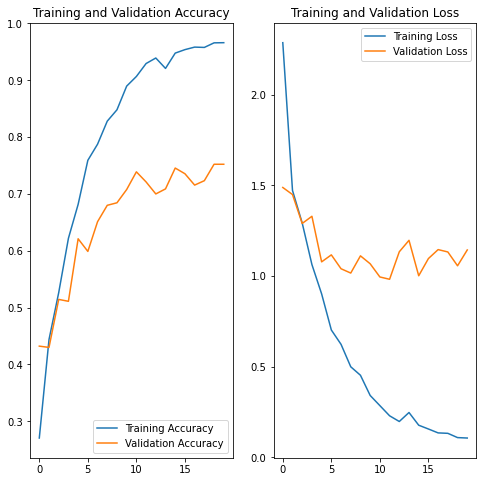

In [83]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

#### Todo: By carefully looking at the plot for training vs validation loss we could noticed that gap between training and validation accuracy have reduced from prior model the difference in accuracy between traiing and validation accuracy is minimal now.

**We can clearly see that the overfitting of the model has reduced significantly when compared the earlier model**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [87]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
**seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
**pigmented benign keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [88]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory="/content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/"+i+"/") 
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB7E0375430>: 100%|██████████| 500/500 [00:27<00:00, 18.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB7E032D730>: 100%|██████████| 500/500 [00:26<00:00, 18.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/dermatofibroma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB7E03C2370>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/melanoma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3872x2592 at 0x7FB7E034EC40>: 100%|██████████| 500/500 [01:50<00:00,  4.54 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/nevus/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB7E0301400>: 100%|██████████| 500/500 [01:38<00:00,  5.10 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB7E02F16A0>: 100%|██████████| 500/500 [00:20<00:00, 24.97 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB7F8049520>: 100%|██████████| 500/500 [00:51<00:00,  9.67 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/squamous cell carcinoma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB7E034E5E0>: 100%|██████████| 500/500 [00:20<00:00, 24.04 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB7E0376670>: 100%|██████████| 500/500 [00:23<00:00, 21.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [89]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [30]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [90]:
df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [91]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
data_dir_train="/content/gdrive/MyDrive/CNN/Skin_ISIC_cancer_data/melanoma_result/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [92]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D()) 

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling

model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.BatchNormalization()) # added
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
#model.add(layers.Dropout(0.2)) # original

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.BatchNormalization()) # added 
model.add(layers.Dropout(0.2)) # added
model.add(layers.Dense(9,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [93]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 batch_normalization_23 (Bat  (None, 90, 90, 128)      512       
 chNormalization)                                    

#### **Todo:**  Train your model

In [94]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


113/113 [==============================] - 49s 305ms/step - loss: 1.9104 - accuracy: 0.3528 - val_loss: 2.0662 - val_accuracy: 0.1500
Epoch 2/30
113/113 [==============================] - 35s 302ms/step - loss: 1.5139 - accuracy: 0.4583 - val_loss: 2.0483 - val_accuracy: 0.2122
Epoch 3/30
113/113 [==============================] - 35s 306ms/step - loss: 1.3715 - accuracy: 0.4961 - val_loss: 2.0545 - val_accuracy: 0.2944
Epoch 4/30
113/113 [==============================] - 38s 327ms/step - loss: 1.2919 - accuracy: 0.5333 - val_loss: 2.9021 - val_accuracy: 0.2633
Epoch 5/30
113/113 [==============================] - 34s 292ms/step - loss: 1.2653 - accuracy: 0.5239 - val_loss: 7.7424 - val_accuracy: 0.2833
Epoch 6/30
113/113 [==============================] - 35s 303ms/step - loss: 1.2147 - accuracy: 0.5606 - val_loss: 4.3705 - val_accuracy: 0.1744
Epoch 7/30
113/113 [==============================] - 35s 303ms/step - loss: 1.1244 - accuracy: 0.5844 - val_loss: 11.0604 - val_accuracy: 0.

#### **Todo:**  Visualize the model results

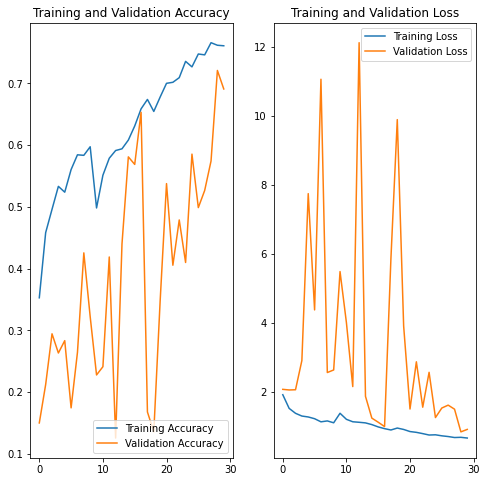

In [95]:
plot_cnn_metrics(history,epochs)

#### **Findings:**
As the training accuracy increases validation accuracy also increases and vice versa.
PLot show the gap between training accuracy and validation accuracy has decreased significantly from the prior models.
Difference between accuracy for Training and Validation data is very less now.

** Class rebalancing helps to address overfitting issues observed from earlier models albeit it also helps to improve accuracy from ~ 50 % to ~70%.**
